In [1]:
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import TransformedBbox, BboxPatch, BboxConnector
from scipy import fft
from tabulate import tabulate
%matplotlib inline
mpl.rcParams['figure.dpi'] = 800
mpl.rc('text', usetex=True)
plt.rcParams.update({'font.size': 7})
font_size = 10

### Import data
copy the data file from postProcessing/forces/0/coefficient.data to ./data folder

In [2]:
f_name = "\\postProcessing\\forces\\0\\coefficient.dat"
fo_name = "E:\\Uni\\Bachelorarbeit\\notebooks\\plot_data\\cases\\"
cases = ['cylinder2D_base_50_100','cylinder2D_base_100_100','cylinder2D_base_150_100','cylinder2D_base_200_100','cylinder2D_base_250_100','cylinder2D_base_300_100','cylinder2D_base_350_100','cylinder2D_base_400_100']
reynolds_number = np.array([50, 100, 150, 200, 250, 300, 350, 400])
mesh_size = 100
data = {}
size = len(cases)
for i in range(0,size):
    data[cases[i]] = np.loadtxt(fo_name+cases[i]+f_name, unpack=True, usecols=[0, 1, 3])

In [3]:
from scipy.signal import argrelmin
from scipy.signal import argrelmax

cd = np.zeros(len(reynolds_number))
ma_cd = np.zeros(len(reynolds_number))
mi_cd = np.zeros(len(reynolds_number))
cl = np.zeros(len(reynolds_number))
ma_cl = np.zeros(len(reynolds_number))
mi_cl = np.zeros(len(reynolds_number))
St = np.zeros(len(reynolds_number))

for i, case in enumerate(cases):
    tml = (np.abs(list(data.values())[i][0] - 5)).argmin()
    tml2 = (np.abs(list(data.values())[i][0] - 8)).argmin()
    
    # cd
    minima = argrelmin(np.abs(list(data.values())[i][1][tml:tml2]),order=5)
    maxima = argrelmax(np.abs(list(data.values())[i][1][tml:tml2]),order=5)
    minima = minima[0]
    maxima = maxima[0]
    
    begin_average_cd = minima[0] + tml
    end_average_cd = maxima[len(maxima)-1] + tml
    max_cd = (list(data.values())[i][1][tml:tml2]).argmax() + tml
    min_cd = (list(data.values())[i][1][tml:tml2]).argmin() + tml
    average_cd = np.round(data[case][1][begin_average_cd:end_average_cd].mean(), 4)
    
    # cl
    minima = argrelmin(list(data.values())[i][2][tml:tml2],order=5)
    maxima = argrelmax(list(data.values())[i][2][tml:tml2],order=5)
    minima = minima[0]
    maxima = maxima[0]
    
    begin_average_cl = minima[0] + tml
    end_average_cl = maxima[len(maxima)-1] + tml
    max_cl = (list(data.values())[i][2][tml:tml2]).argmax() + tml
    min_cl = (list(data.values())[i][2][tml:tml2]).argmin() + tml
    average_cl = np.round(data[case][2][begin_average_cl:end_average_cl].mean(), 4)
    
    #frequency
    
    # sine fit
    
    def fit_sin(tt, yy):
        '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
        tt = np.array(tt)
        yy = np.array(yy)
        ff = np.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
        Fyy = abs(np.fft.fft(yy))
        guess_freq = abs(ff[np.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
        guess_amp = np.std(yy) * 2.**0.5
        guess_offset = np.mean(yy)
        guess = np.array([guess_amp, 2.*np.pi*guess_freq, 0., guess_offset])

        def sinfunc(t, A, w, p, c):  return A * np.sin(w*t + p) + c
        popt, pcov = scipy.optimize.curve_fit(sinfunc, tt, yy, p0=guess)
        A, w, p, c = popt
        f = w/(2.*np.pi)
        fitfunc = lambda t: A * np.sin(w*t + p) + c
        return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": np.max(pcov), "rawres": (guess,popt,pcov)}

    t = data[case][0][tml:tml2]
    y = data[case][2][tml:tml2]
    res = fit_sin(t,y)
    f_sin_fit = res["freq"]
    St_sin_fit = f_sin_fit * 0.1/(reynolds_number[i]/100)
    
    print("Case " + case + ":")
    print("mean drag/lift: {:2.4f}/{:2.4f}".format(average_cd, average_cl))
    print("Max drag: {:2.4f}".format(data[case][1][max_cd]))
    print("Min drag: {:2.4f}".format(data[case][1][min_cd]))
    print("Max lift: {:2.4f}".format(data[case][2][max_cl]))
    print("Min lift: {:2.4f}".format(data[case][2][min_cl]))
    print("Frequency: {:2.4f} Hz".format(f_sin_fit))
    print("Strouhal number: {:2.4f}".format(St_sin_fit))
    print("")
    
    cd[i] = average_cd
    ma_cd[i] = data[case][1][max_cd]
    mi_cd[i] = data[case][1][min_cd]
    cl[i] = average_cl
    ma_cl[i] = data[case][2][max_cl]
    mi_cl[i] = data[case][2][min_cl]
    St[i] = St_sin_fit

Case cylinder2D_base_50_100:
mean drag/lift: 3.6985/-0.0113
Max drag: 3.6986
Min drag: 3.6985
Max lift: 0.0098
Min lift: -0.0323
Frequency: 1.3353 Hz
Strouhal number: 0.2671

Case cylinder2D_base_100_100:
mean drag/lift: 3.1939/-0.0191
Max drag: 3.2240
Min drag: 3.1633
Max lift: 0.9681
Min lift: -1.0044
Frequency: 2.9978 Hz
Strouhal number: 0.2998

Case cylinder2D_base_150_100:
mean drag/lift: 3.1298/-0.0234
Max drag: 3.2204
Min drag: 3.0389
Max lift: 1.6447
Min lift: -1.6906
Frequency: 4.6667 Hz
Strouhal number: 0.3111

Case cylinder2D_base_200_100:
mean drag/lift: 3.1414/-0.0255
Max drag: 3.2931
Min drag: 2.9894
Max lift: 2.1080
Min lift: -2.1622
Frequency: 6.3786 Hz
Strouhal number: 0.3189

Case cylinder2D_base_250_100:
mean drag/lift: 3.1581/-0.0267
Max drag: 3.3578
Min drag: 2.9581
Max lift: 2.4041
Min lift: -2.4654
Frequency: 8.1273 Hz
Strouhal number: 0.3251

Case cylinder2D_base_300_100:
mean drag/lift: 3.1728/-0.0279
Max drag: 3.4092
Min drag: 2.9378
Max lift: 2.5969
Min lift:

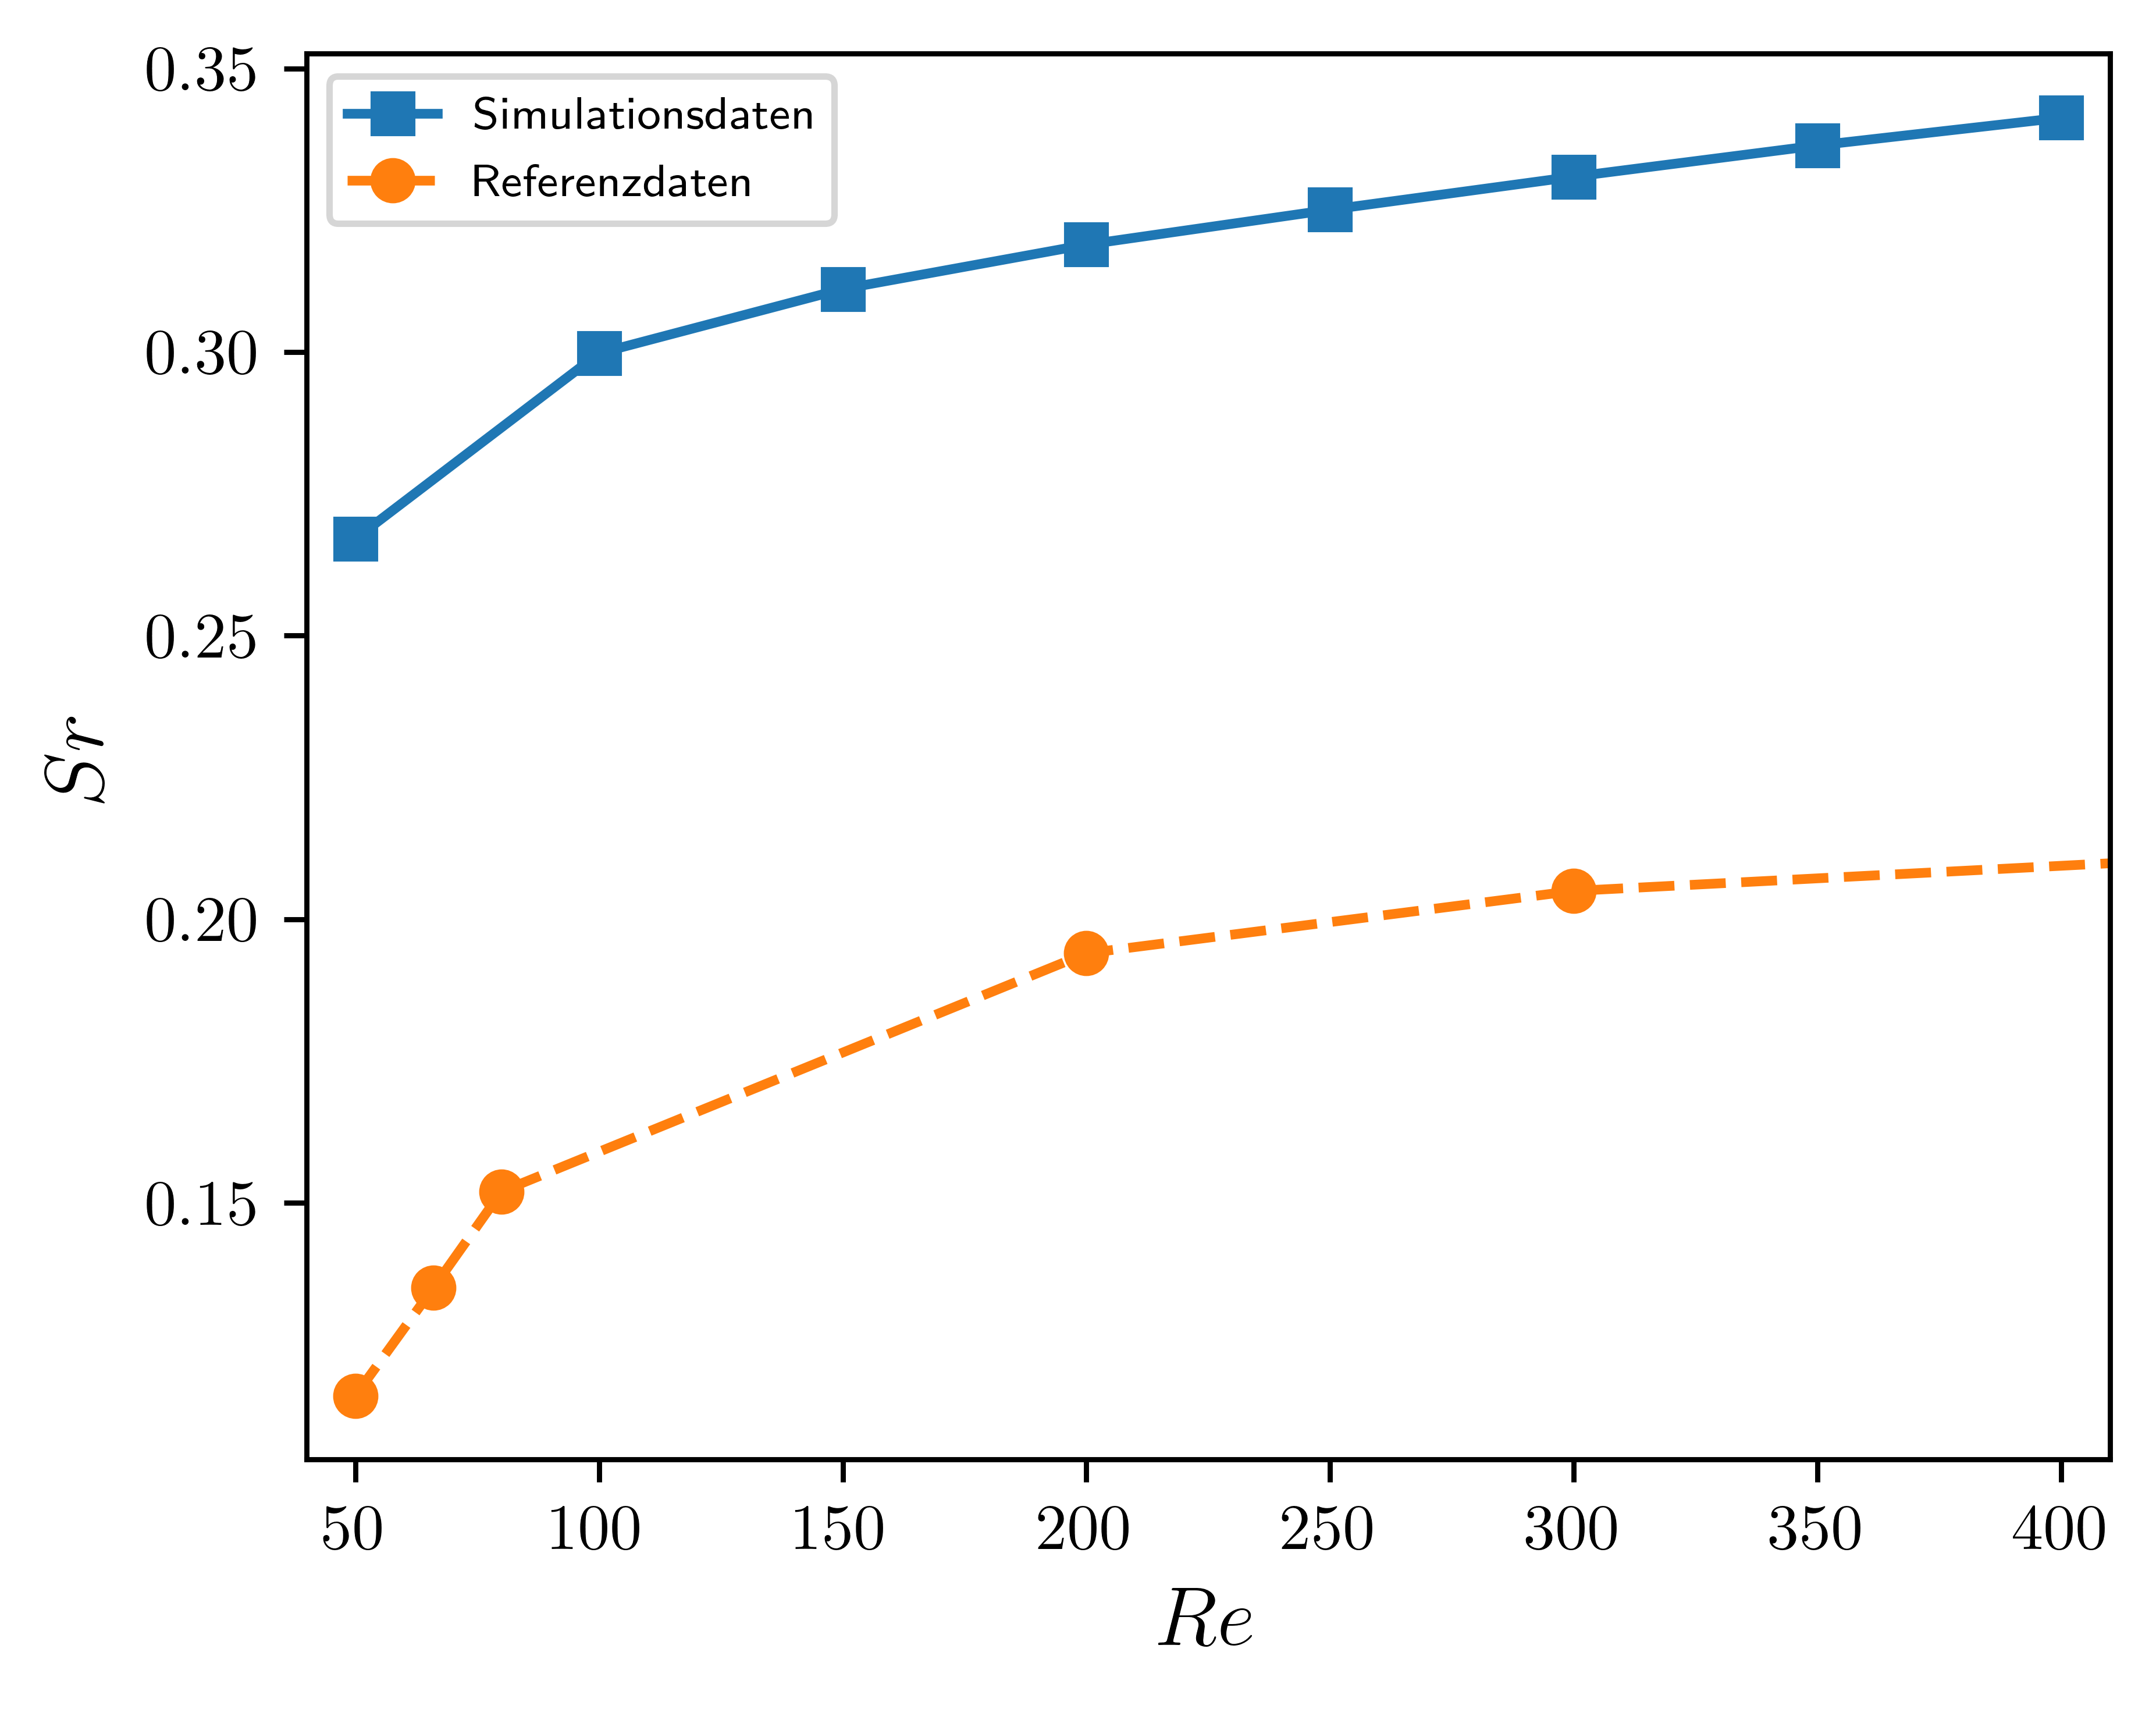

In [4]:
reference_data_St = np.array([0.116, 0.135, 0.152, 0.194, 0.205, 0.236])
reference_data_Re = np.array([50, 66, 80, 200, 300, 1000])

fig, ax = plt.subplots(figsize=(5,4))

ax.plot(reynolds_number, St, '-s', label="Simulationsdaten")
ax.plot(reference_data_Re, reference_data_St, '--o', label="Referenzdaten")
ax.legend()
ax.tick_params(labelsize=font_size)
ax.set_ylabel(r"$Sr$", fontsize=font_size+3)
ax.set_xlabel(r"$Re$", fontsize=font_size+3)
ax.set_xlim((40,410))
fig.savefig('St_over_Re')

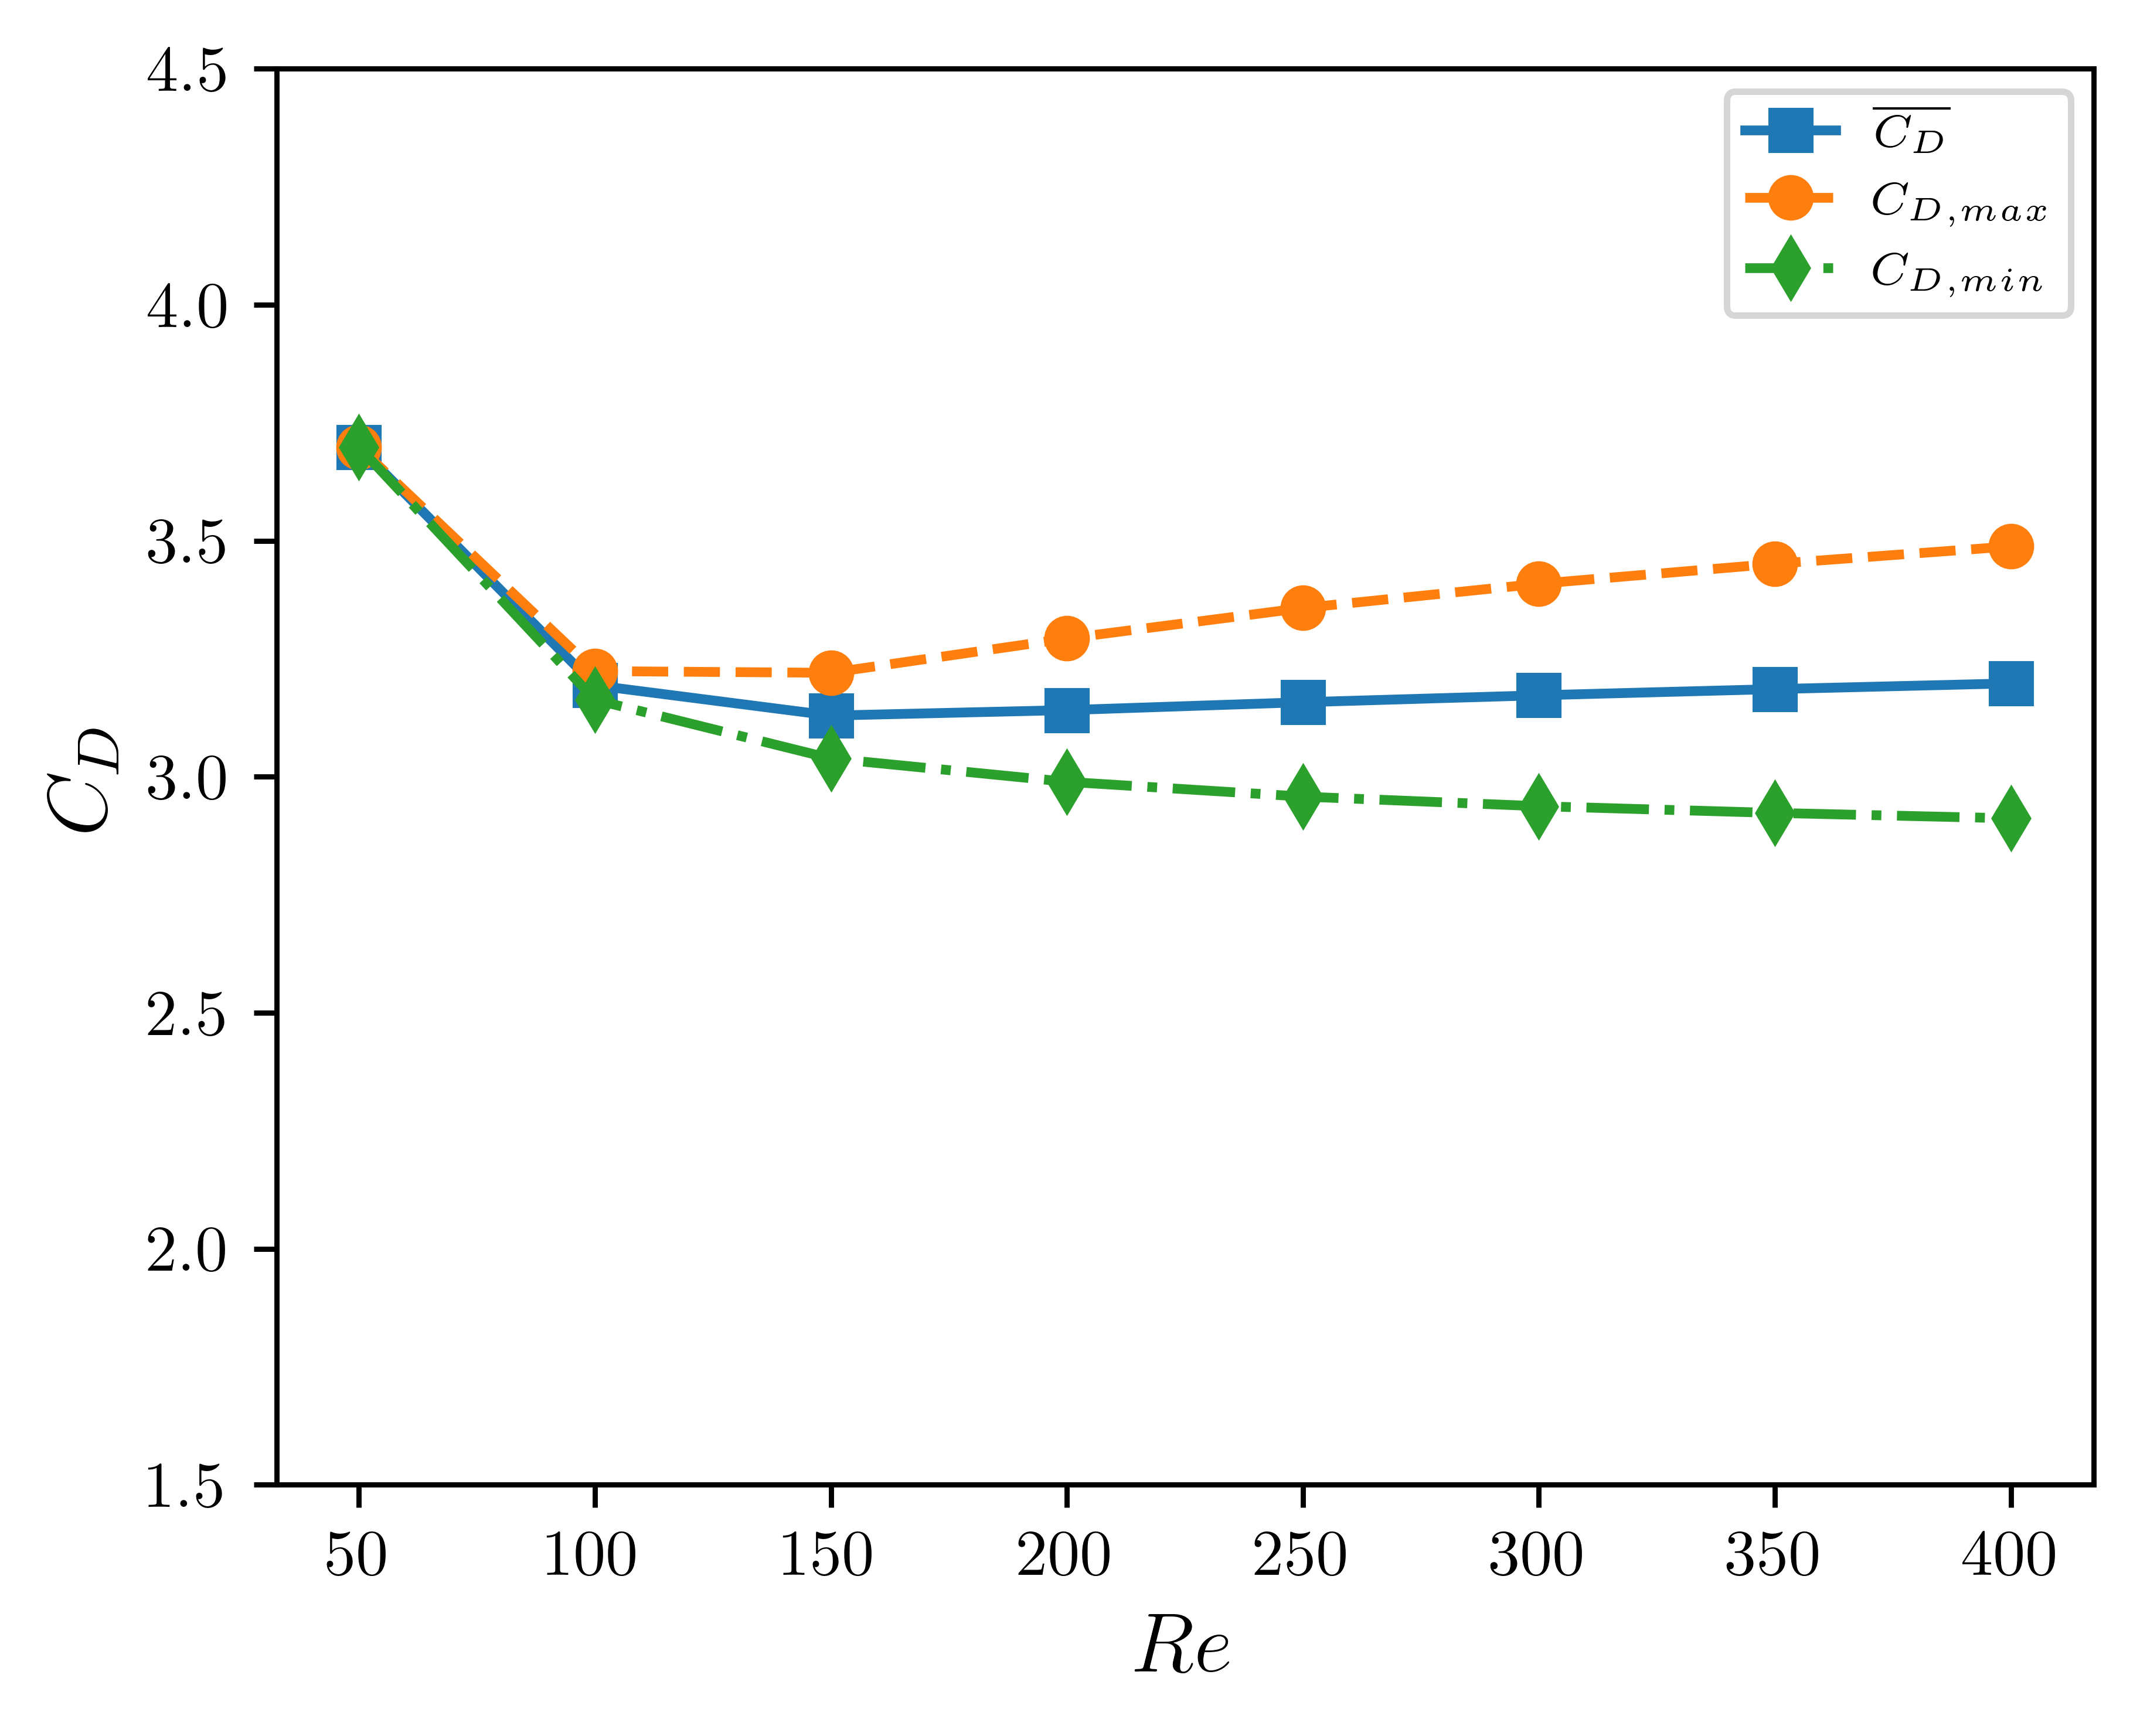

In [8]:
fig, ax = plt.subplots(figsize=(5,4))

ax.plot(reynolds_number, cd, '-s', label="$\overline{C_D}$")
ax.plot(reynolds_number, ma_cd, '--o', label="$C_{D,max}$")
ax.plot(reynolds_number, mi_cd, '-.d', label="$C_{D,min}$")
ax.legend()
ax.tick_params(labelsize=font_size)
ax.set_ylabel(r"$C_D$", fontsize=font_size+3)
ax.set_xlabel(r"$Re$", fontsize=font_size+3)
ax.set_ylim(1.5,4.5)


fig.savefig('Cd_over_Re')

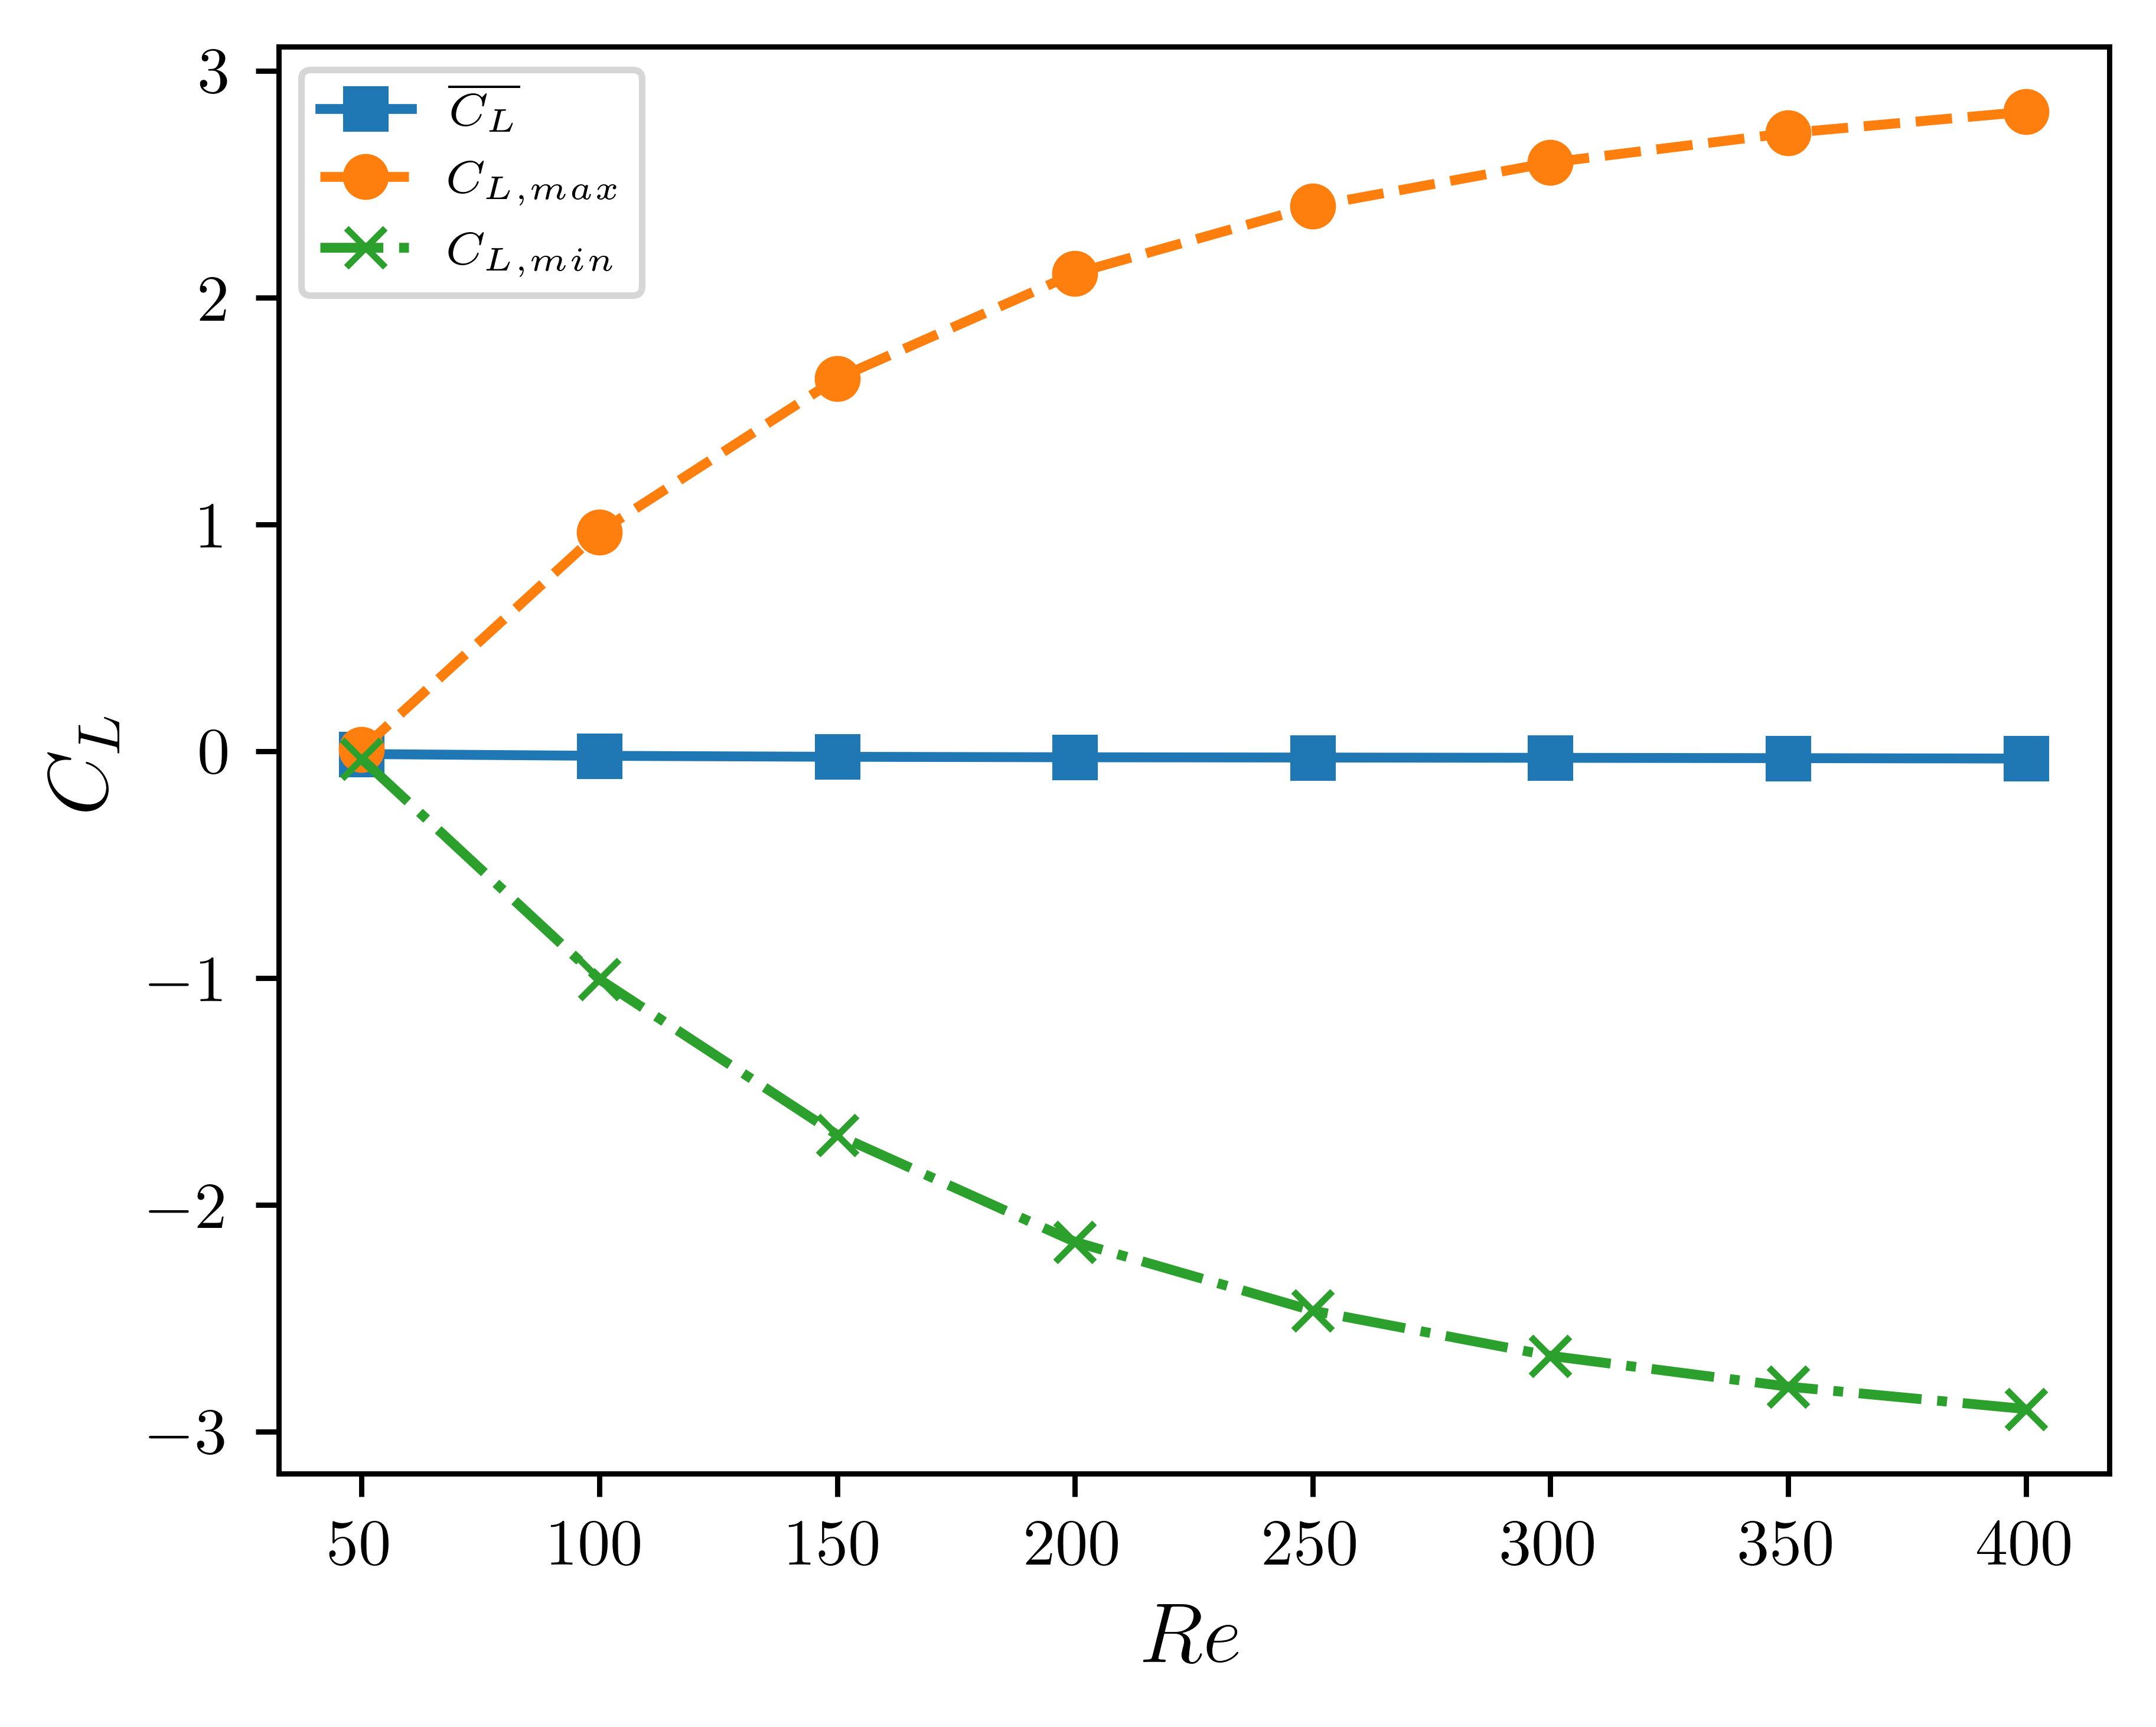

In [6]:
fig, ax = plt.subplots(figsize=(5,4))

ax.plot(reynolds_number, cl, '-s', label="$\overline{C_L}$")
ax.plot(reynolds_number, ma_cl, '--o', label="$C_{L,max}$")
ax.plot(reynolds_number, mi_cl, '-.x', label="$C_{L,min}$")
ax.legend()
ax.tick_params(labelsize=font_size)
ax.set_ylabel(r"$C_L$", fontsize=font_size+3)
ax.set_xlabel(r"$Re$", fontsize=font_size+3)
# ax.set_ylim(1.5,4.5)


fig.savefig('Cl_over_Re')

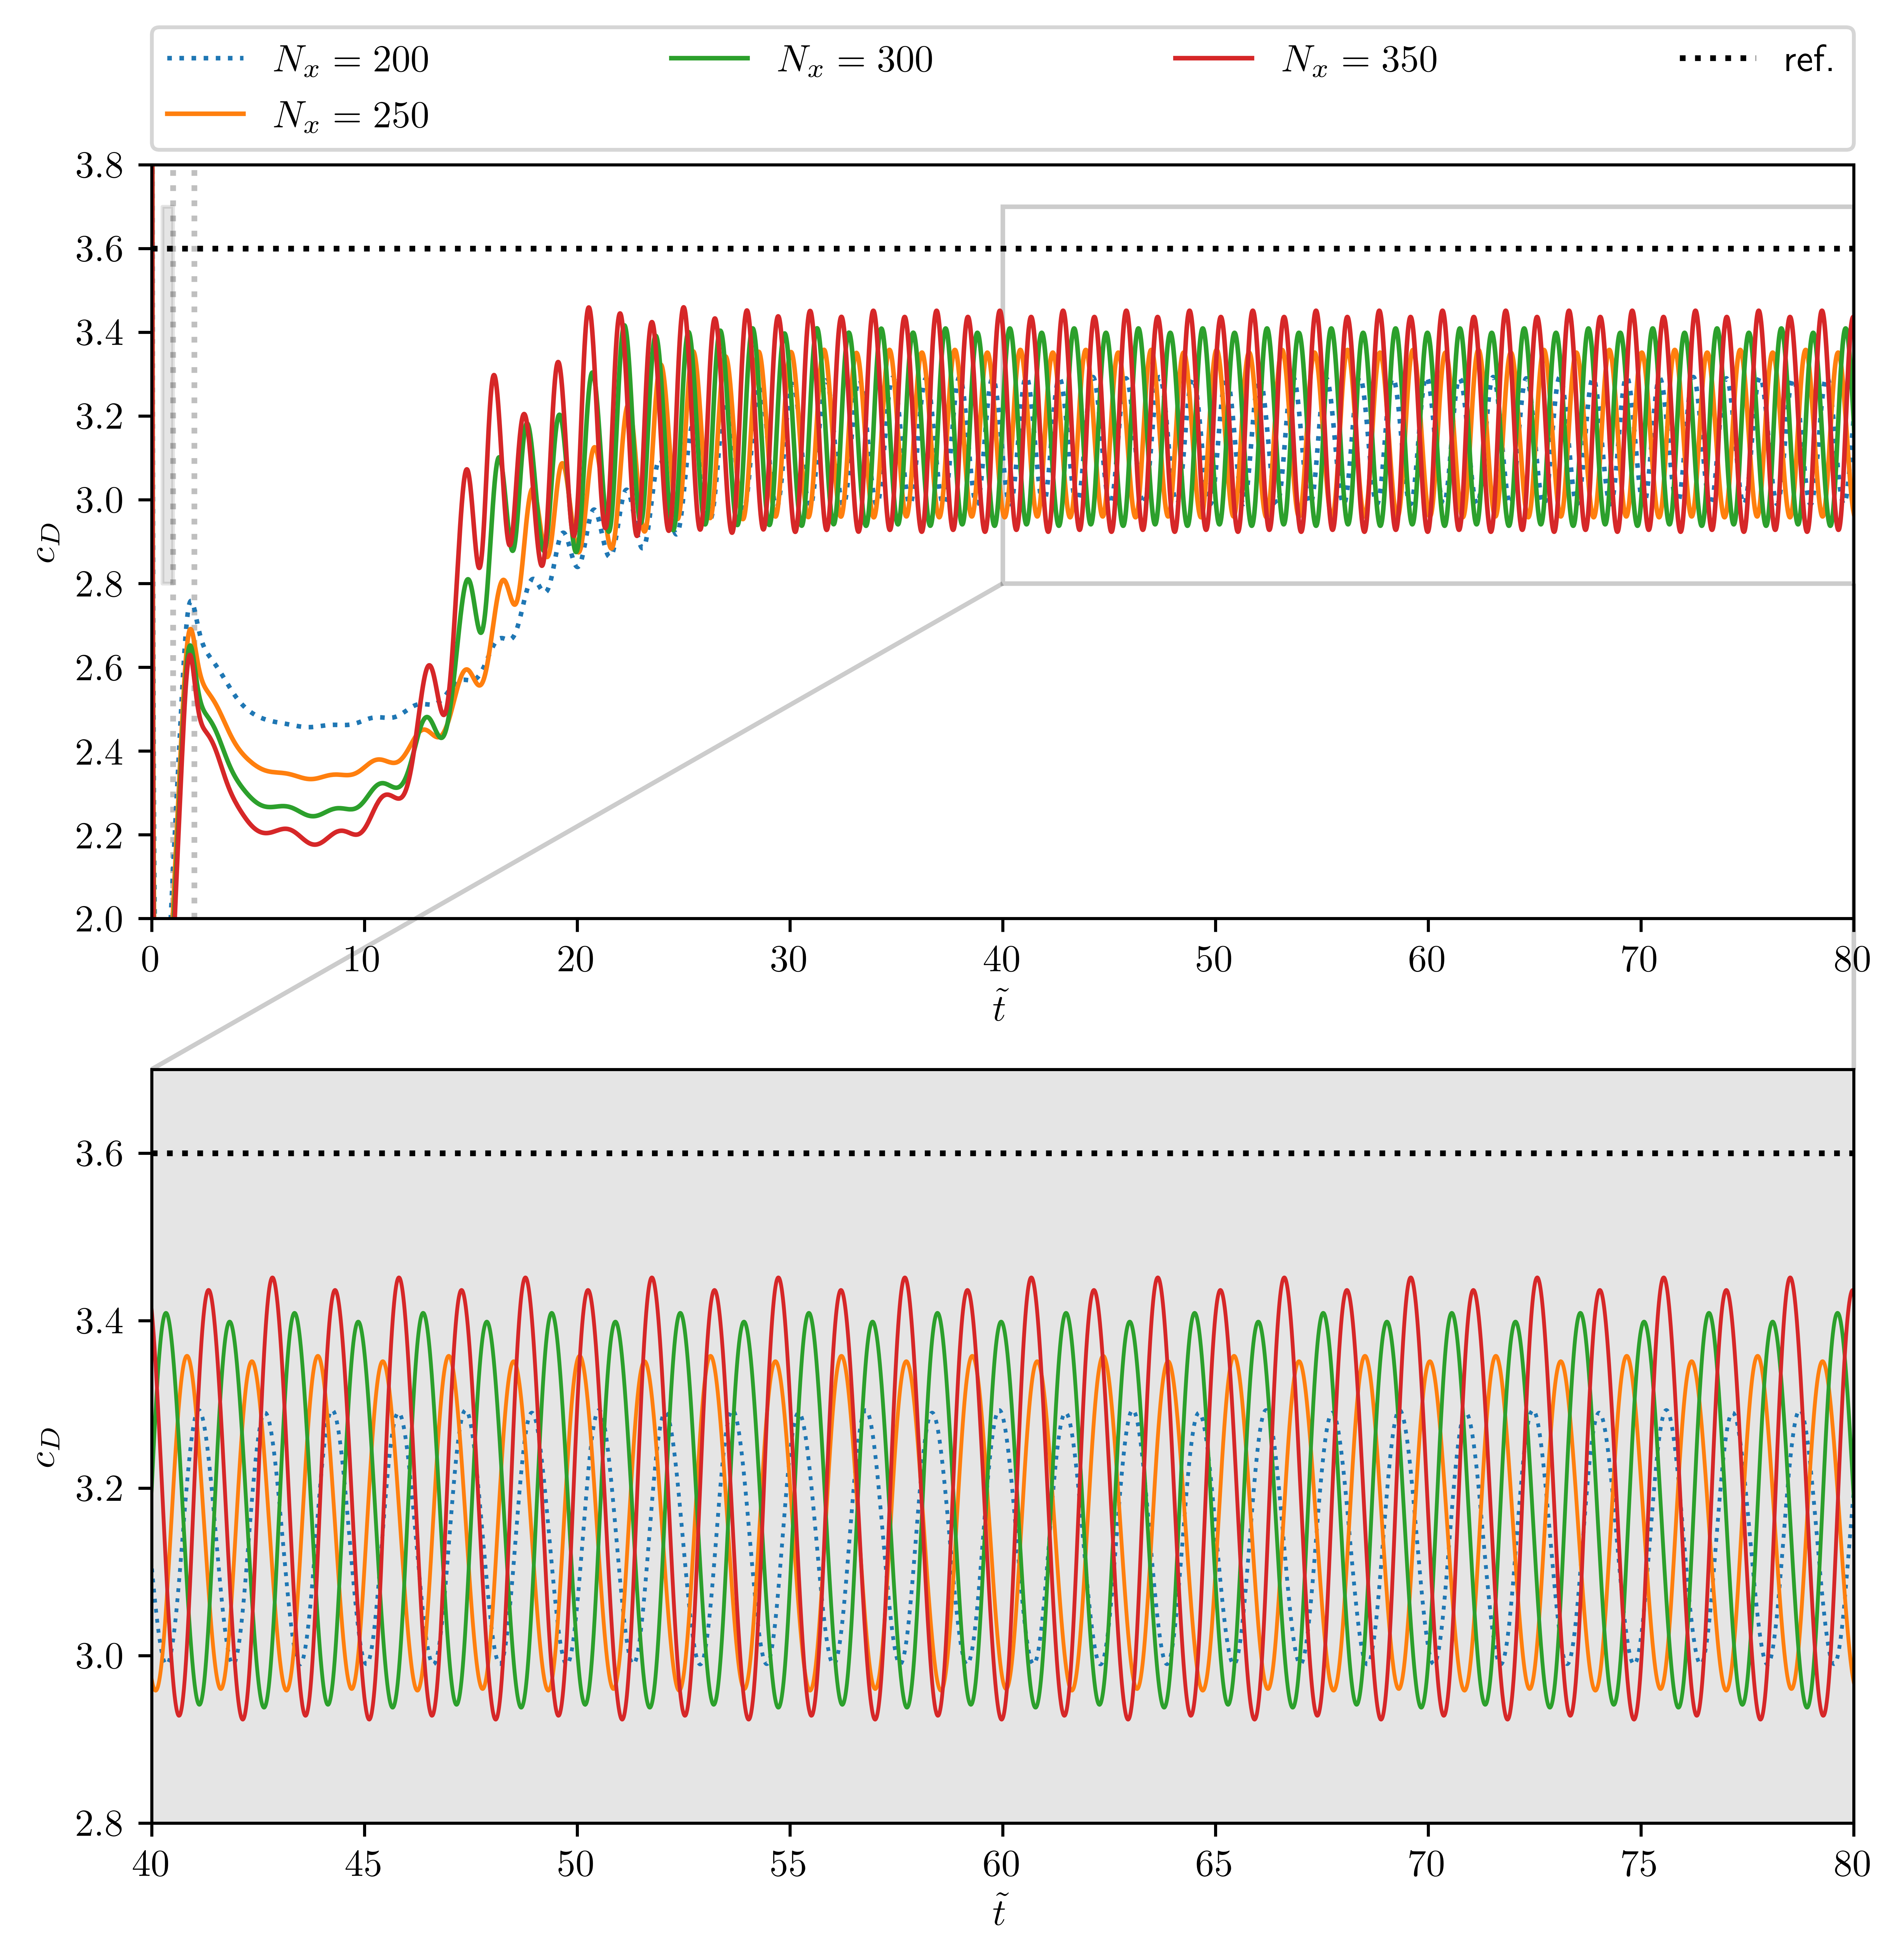

In [7]:
markers = ["o","+","s","h","o","o","o","o","o"]
lines = ['-.',"--","-",":","-","-","-","-","-"]
colors = ['#047495',"teal",'#c04e01',"red","red","red","red","red","red"] 

diameter = 0.1
labels = [r'$N_x={:d}$'.format(cells) for cells in reynolds_number]

fig, (ax1, ax2) = plt.subplots(nrows=2,figsize=(8,8))

#ax1 = plt.axes(upper_plot_bounds, xticks=[], xlim=[t_min, t_max], ylim=[0, 10])
ax1.fill_between([0.5, 1], [2.8, 2.8], [3.7, 3.7], color='k', alpha=0.1) #[-1, 120]
ax1.tick_params(labelsize=font_size)
ax1.set_ylim((2,3.8))
ax1.set_ylabel(r"$c_D$", fontsize=font_size)
ax1.set_xlim((0,80))
ax1.set_xlabel(r"$\tilde{t}$", fontsize=font_size)
ax1.axvline(1, ls=":", color="k", alpha=0.25)
ax1.axvline(2, ls=":", color="k", alpha=0.25)

#ax2 = plt.axes(lower_plot_bounds, yticks=[7.0, 7.5, 8.0, 8.5], xlim=[t_min, t_max], ylim=[re_zoom_min, re_zoom_max])
ax2.patch.set_facecolor('k')
ax2.patch.set_alpha(0.1)
ax2.set_ylabel(r"$c_D$", fontsize=font_size)
ax2.set_xlabel(r"$\tilde{t}$", fontsize=font_size)
ax2.tick_params(labelsize=font_size)
ax2.set_xlim((40,80))
ax2.set_ylim((2.92,3.25))
ax2.set_ylim((2.8, 3.7))

# plotting
for i, case in enumerate(cases):
    if 2<i<7:
        ax1.plot(data[case][0]*reynolds_number[i]/100/diameter,data[case][1], lines[i], linewidth=1.2, markevery=70, label=labels[i])
        ax2.plot(data[case][0]*reynolds_number[i]/100/diameter,data[case][1],lines[i], linewidth=1, markevery=70,  label=labels[i])
ax1.axhline(3.6, ls=":", markevery=0.05, color="k", label="ref.")
ax2.axhline(3.6, ls=":", markevery=0.05, color="k", label="ref.")

# for box and lines
def mark_inset(parent_axes, inset_axes, loc1a=1, loc1b=1, loc2a=2, loc2b=2, **kwargs):
    rect = TransformedBbox(inset_axes.viewLim, parent_axes.transData)

    pp = BboxPatch(rect, fill=False, linewidth=1.2, **kwargs)
    parent_axes.add_patch(pp)

    p1 = BboxConnector(inset_axes.bbox, rect, loc1=loc1a, loc2=loc1b, linewidth=1.2, **kwargs)
    inset_axes.add_patch(p1)
    p1.set_clip_on(False)
    p2 = BboxConnector(inset_axes.bbox, rect, loc1=loc2a, loc2=loc2b, linewidth=1.2, **kwargs)
    inset_axes.add_patch(p2)
    p2.set_clip_on(False)

    return pp, p1, p2

mark_inset(ax1, ax2, loc1a=1, loc1b=4, loc2a=2, loc2b=3, fc="none", ec="k", alpha=0.2) 

# for legend
ax1.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=4, mode="expand", borderaxespad=0., fontsize=font_size)

# text in plot
# ax2.text(0.53, 3.64, r"Vergrößerte Ansicht $ \tilde t ={:.1f}...{:.0f}$".format(0.5, 1), fontsize=font_size+1, color='k')
# ax1.text(0.51, 2.5, r"$ \tilde t =0.5$", rotation=90, fontsize=font_size, color='k', alpha=0.8)
# ax1.text(0.98, 2.6, r"$ \tilde t =1$", rotation=90, fontsize=font_size, color='k', alpha=0.8)
# ax2.text(0.75, 3.62, r"ref. $ c_D =3.6$", fontsize=font_size, color='k')

fig.savefig('cd_over_t_varying_Re.png')